<a href="https://colab.research.google.com/github/Jando3/BmwDataProject/blob/main/c964ComputerScienceCapstoneJuanSandoval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
import os

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
path = kagglehub.dataset_download("sumedh1507/bmw-car-sales-dataset")
print("Path to dataset files:", path)

files = os.listdir(path)
csv_files = [f for f in files if f.lower().endswith(".csv")]
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {path}. Found: {files}")

csv_file = csv_files[0]
df_raw = pd.read_csv(os.path.join(path, csv_file))
print(f"Loaded: {csv_file} | shape={df_raw.shape}")

100%|██████████| 828k/828k [00:00<00:00, 13.4MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/sumedh1507/bmw-car-sales-dataset/versions/1


Loaded: BMW_Car_Sales_Classification.csv | shape=(50000, 11)


In [3]:
# Locate dataset downloaded via kagglehub
dataset_path = "/root/.cache/kagglehub/datasets/sumedh1507/bmw-car-sales-dataset/versions/1"
csv_file = "BMW_Car_Sales_Classification.csv"

df = pd.read_csv(os.path.join(dataset_path, csv_file))

# Filter for North America and years 2020–2024
mask = (
    df["Region"].str.strip().str.lower().eq("north america")
    & df["Year"].between(2020, 2024)
)

df_na = df.loc[mask].copy()

print("Filtered NA 2020–2024 shape:", df_na.shape)

# Optional: save the filtered dataset
df_na.to_csv("north_america_2020_2024.csv", index=False)

# Preview the original dataframe
df.head()

Filtered NA 2020–2024 shape: (2776, 11)


,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High
1,i8,2013,North America,Red,Hybrid,Automatic,1.6,121671,79219,3428,Low
2,5 Series,2022,North America,Blue,Petrol,Automatic,4.5,10991,113265,6994,Low
3,X3,2024,Middle East,Blue,Petrol,Automatic,1.7,27255,60971,4047,Low
4,7 Series,2020,South America,Black,Diesel,Manual,2.1,122131,49898,3080,Low


In [4]:
df = pd.read_csv("north_america_2020_2024.csv")
print(df.shape)
print(df.describe())
df.isna().sum()
print(df.select_dtypes(include=[np.number]).corr())


(2776, 11)
              Year  Engine_Size_L     Mileage_KM      Price_USD  Sales_Volume
count  2776.000000    2776.000000    2776.000000    2776.000000   2776.000000
mean   2022.042147       3.247550  102366.983429   75107.609510   5151.913545
std       1.409884       1.011463   57591.479324   25975.932244   2870.137085
min    2020.000000       1.500000      43.000000   30032.000000    100.000000
25%    2021.000000       2.400000   53920.250000   52617.500000   2658.000000
50%    2022.000000       3.200000  103565.500000   74444.000000   5189.000000
75%    2023.000000       4.100000  152331.750000   97990.750000   7647.500000
max    2024.000000       5.000000  199840.000000  119963.000000   9988.000000
                   Year  Engine_Size_L  Mileage_KM  Price_USD  Sales_Volume
Year           1.000000      -0.016871   -0.021299   0.022016     -0.023206
Engine_Size_L -0.016871       1.000000    0.001326   0.006336     -0.004405
Mileage_KM    -0.021299       0.001326    1.000000  -0.0315

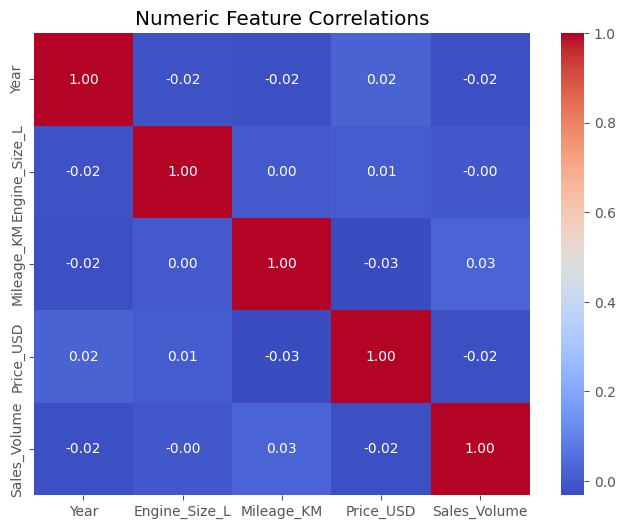

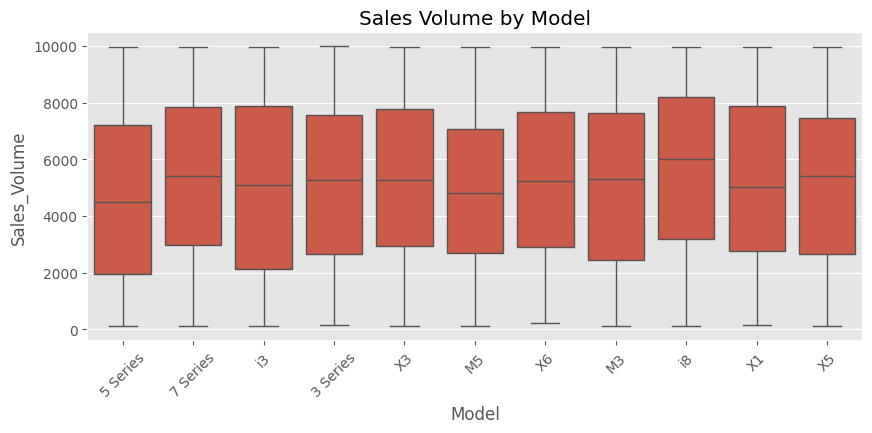

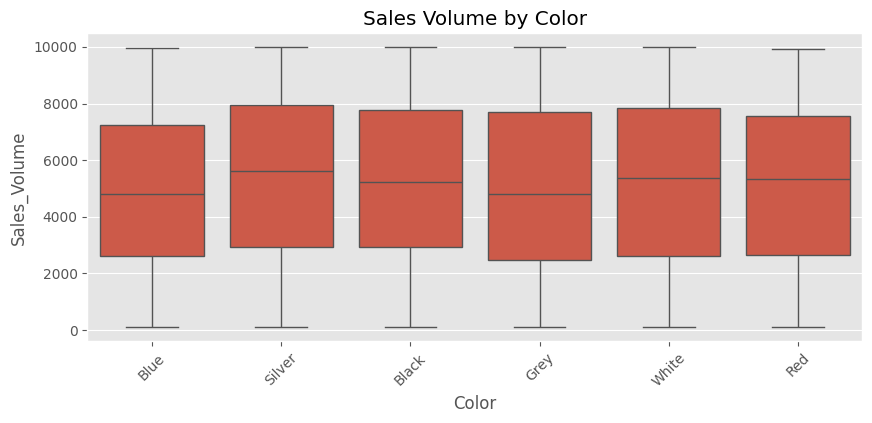

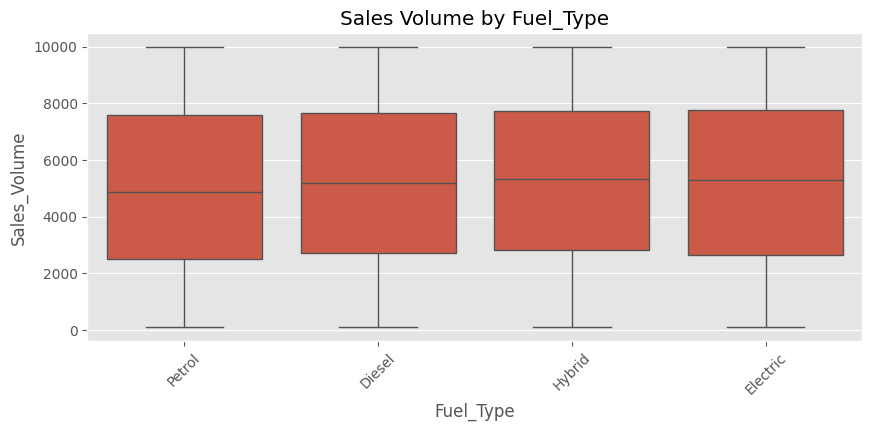

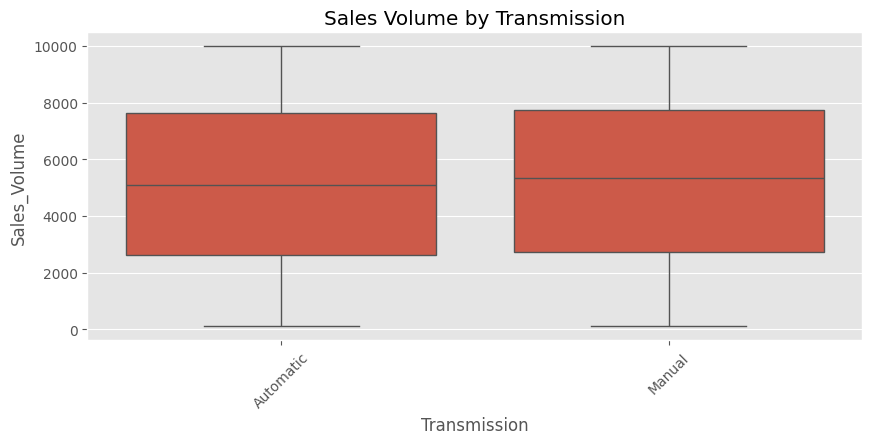


Average Sales by Model:
Model
i8          5574.358491
7 Series    5349.636719
X3          5322.092000
X1          5257.212766
X6          5172.717054
3 Series    5158.665370
X5          5105.051793
M3          5045.646388
i3          5040.867704
M5          4843.511450
5 Series    4755.936937
Name: Sales_Volume, dtype: float64

Average Sales by Color:
Color
Silver    5404.561181
Black     5188.732301
White     5186.746137
Red       5179.123431
Blue      5004.440449
Grey      4941.877637
Name: Sales_Volume, dtype: float64

Average Sales by Fuel_Type:
Fuel_Type
Hybrid      5241.590782
Electric    5221.155492
Diesel      5143.141757
Petrol      5001.132394
Name: Sales_Volume, dtype: float64

Average Sales by Transmission:
Transmission
Manual       5205.727009
Automatic    5098.640143
Name: Sales_Volume, dtype: float64


In [6]:
# ----------------------
# 1) Correlation heatmap for numeric features
# ----------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Numeric Feature Correlations")
plt.show()

# ----------------------
# 2) Boxplots: Sales_Volume by categorical features
# ----------------------
categorical_cols = ['Model', 'Color', 'Fuel_Type', 'Transmission']

for col in categorical_cols:
    plt.figure(figsize=(10,4))
    sns.boxplot(x=col, y='Sales_Volume', data=df)
    plt.xticks(rotation=45)
    plt.title(f"Sales Volume by {col}")
    plt.show()

# ----------------------
# 3) Optional: Mean sales per category
# ----------------------
for col in categorical_cols:
    print(f"\nAverage Sales by {col}:")
    print(df.groupby(col)['Sales_Volume'].mean().sort_values(ascending=False))

In [7]:
feature_cols_num = ["Year", "Engine_Size_L", "Price_USD"]
feature_cols_cat = ["Model", "Color", "Fuel_Type", "Transmission", "Region"]
target_col = "Sales_Volume"

X = df_na[feature_cols_num + feature_cols_cat].copy()
y = df_na[target_col].copy()

# ----------------------------
# 5) ML Pipeline
# ----------------------------
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, feature_cols_num),
        ("cat", categorical_transformer, feature_cols_cat),
    ],
    remainder="drop"
)

model = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model)
])

# ----------------------------
# 6) Train / Test split & Train
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pipe.fit(X_train, y_train)

# ----------------------------
# 7) Evaluate
# ----------------------------
pred = pipe.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))  # Manual RMSE calc
r2 = r2_score(y_test, pred)
print(f"Eval -> RMSE: {rmse:,.2f} | R^2: {r2:,.3f}")

Eval -> RMSE: 2,985.67 | R^2: -0.056


In [8]:
# ----------------------------
# 1) Extract real combinations from 2020–2024
# ----------------------------
real_combos = df[["Model","Engine_Size_L","Color","Fuel_Type","Transmission","Price_USD"]].drop_duplicates().copy()

# Optionally, filter for top models/colors/fuel types to reduce candidate grid
top_models = df.groupby("Model")["Sales_Volume"].mean().sort_values(ascending=False).head(5).index.tolist()
top_colors = df.groupby("Color")["Sales_Volume"].mean().sort_values(ascending=False).head(3).index.tolist()
top_fuels  = df.groupby("Fuel_Type")["Sales_Volume"].mean().sort_values(ascending=False).head(2).index.tolist()

real_combos = real_combos[
    (real_combos["Model"].isin(top_models)) &
    (real_combos["Color"].isin(top_colors)) &
    (real_combos["Fuel_Type"].isin(top_fuels))
].copy()

# Add forecast year and region
TARGET_YEAR = 2025
real_combos["Year"] = TARGET_YEAR
real_combos["Region"] = "North America"

# ----------------------------
# 2) Predict sales for each combo
# ----------------------------
feature_cols_num = ["Year", "Engine_Size_L", "Price_USD"]
feature_cols_cat = ["Model", "Color", "Fuel_Type", "Transmission", "Region"]

# Use your trained pipeline to predict
real_combos["Predicted_Sales"] = pipe.predict(real_combos[feature_cols_num + feature_cols_cat])

# ----------------------------
# 3) Compute recommended order quantity with buffer
# ----------------------------
SAFETY_FACTOR = 0.10  # +10% buffer
ORDER_MULTIPLE = 5    # round to nearest multiple of 5

def round_up_to_multiple(x, multiple):
    return int(np.ceil(x * (1 + SAFETY_FACTOR) / multiple) * multiple)

real_combos["Recommended_Order_Qty"] = real_combos["Predicted_Sales"].apply(lambda x: round_up_to_multiple(x, ORDER_MULTIPLE))

# ----------------------------
# 4) Rank by predicted sales and get top 20 combos
# ----------------------------
top_recs_real = real_combos.sort_values("Predicted_Sales", ascending=False).head(20).reset_index(drop=True)
cols_out = ["Model", "Engine_Size_L", "Color", "Fuel_Type", "Transmission", "Price_USD", "Predicted_Sales", "Recommended_Order_Qty"]
top_recs_real = top_recs_real[cols_out]

print("Top 20 forecasted combos for 2025:")
print(top_recs_real)

# ----------------------------
# 5) Allocate 250 cars per quarter
# ----------------------------
TOTAL_CARS_PER_QUARTER = 250
total_pred = top_recs_real["Recommended_Order_Qty"].sum()

top_recs_real["Quarter_Order_Qty"] = (top_recs_real["Recommended_Order_Qty"] / total_pred * TOTAL_CARS_PER_QUARTER).round().astype(int)

# Adjust for rounding differences
diff = TOTAL_CARS_PER_QUARTER - top_recs_real["Quarter_Order_Qty"].sum()
if diff != 0:
    top_idx = top_recs_real["Predicted_Sales"].idxmax()
    top_recs_real.loc[top_idx, "Quarter_Order_Qty"] += diff

print("\nQuarterly allocation for 250 cars:")
print(top_recs_real[["Model","Engine_Size_L","Color","Fuel_Type","Transmission","Quarter_Order_Qty"]])
print("Total cars allocated:", top_recs_real["Quarter_Order_Qty"].sum())

Top 20 forecasted combos for 2025:
       Model  Engine_Size_L   Color Fuel_Type Transmission  Price_USD  \
0         X3            3.1   White  Electric       Manual     106681   
1         i8            3.8  Silver    Hybrid       Manual      54166   
2         i8            3.0   White    Hybrid    Automatic      37136   
3         X3            2.5   White  Electric    Automatic     100633   
4   7 Series            1.8  Silver    Hybrid       Manual      50176   
5         X6            4.2  Silver  Electric    Automatic      52777   
6         X3            2.6   Black    Hybrid       Manual      84441   
7   7 Series            4.9  Silver    Hybrid       Manual      54162   
8   7 Series            4.7   White  Electric       Manual     103306   
9         i8            3.2   White    Hybrid    Automatic      34220   
10        X1            4.3  Silver    Hybrid       Manual      57968   
11        X3            2.5   White    Hybrid    Automatic     104533   
12  7 Series    

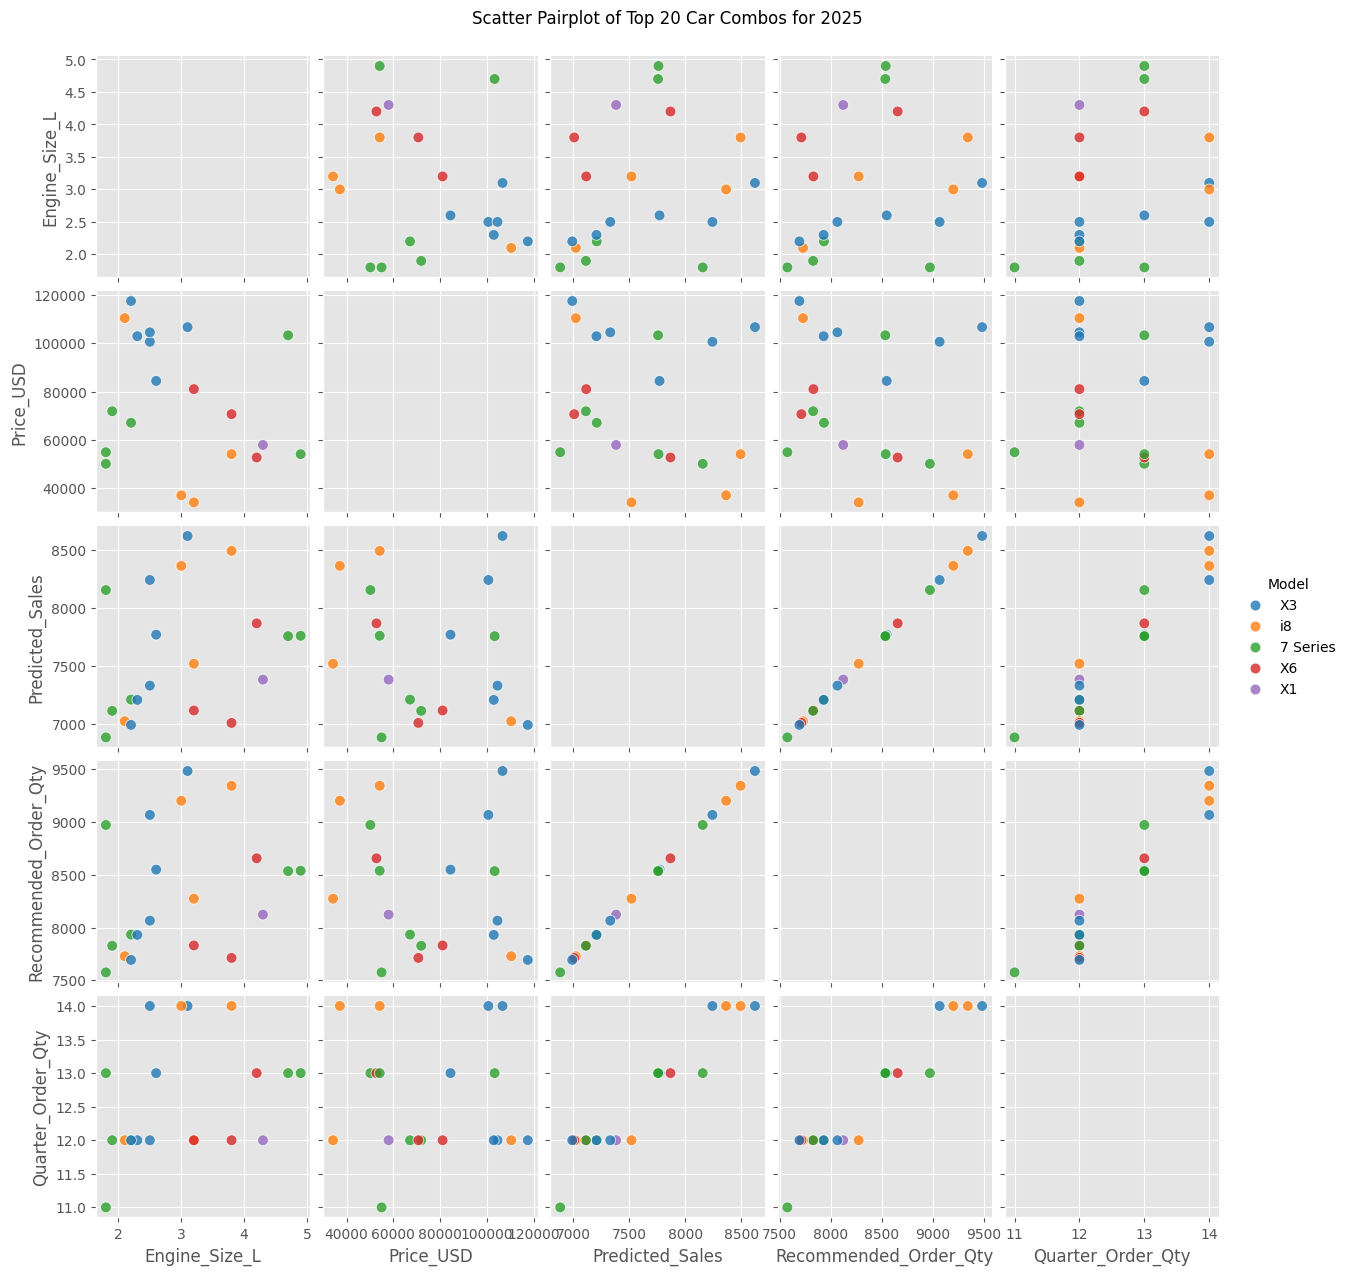

In [9]:
# ----------------------------
# Example: your Top 20 combos DataFrame
# ----------------------------
# Assume top_recs_real already exists and includes Predicted_Sales
# If not, rebuild it as in your previous code.

# Make sure Recommended_Order_Qty exists
ORDER_MULTIPLE = 1
SAFETY_FACTOR = 0.10

def round_up_to_multiple(x, multiple):
    return int(np.ceil(x * (1 + SAFETY_FACTOR) / multiple) * multiple)

top_recs_real["Recommended_Order_Qty"] = top_recs_real["Predicted_Sales"].apply(lambda x: round_up_to_multiple(x, ORDER_MULTIPLE))

# Allocate 250 cars per quarter
TOTAL_CARS_PER_QUARTER = 250
total_pred = top_recs_real["Recommended_Order_Qty"].sum()
top_recs_real["Quarter_Order_Qty"] = (top_recs_real["Recommended_Order_Qty"] / total_pred * TOTAL_CARS_PER_QUARTER).round().astype(int)

# ----------------------------
# Scatter pairplot with only dots
# ----------------------------
numeric_cols = ["Engine_Size_L", "Price_USD", "Predicted_Sales", "Recommended_Order_Qty", "Quarter_Order_Qty"]

# Pairplot with scatter points only
sns.pairplot(
    top_recs_real,
    vars=numeric_cols,
    hue="Model",
    palette="tab10",
    diag_kind="scatter",      # make diagonal scatter as well
    plot_kws={"s": 60, "alpha": 0.8}  # adjust dot size and transparency
)

plt.suptitle("Scatter Pairplot of Top 20 Car Combos for 2025", y=1.02)
plt.show()

=== DEALERSHIP INVENTORY ALLOCATION ===
Total Units to Allocate: 250
Total Weight: 252

Allocation per Model & Color:
--------------------------------------------------
X3           | White     :  62 units (  64 weight,  24.8%)
7 Series     | Silver    :  38 units (  38 weight,  15.2%)
i8           | White     :  38 units (  38 weight,  15.2%)
7 Series     | White     :  25 units (  25 weight,  10.0%)
i8           | Silver    :  14 units (  14 weight,   5.6%)
X3           | Black     :  13 units (  13 weight,   5.2%)
X6           | Silver    :  13 units (  13 weight,   5.2%)
X1           | Silver    :  12 units (  12 weight,   4.8%)
X6           | Black     :  12 units (  12 weight,   4.8%)
X6           | White     :  12 units (  12 weight,   4.8%)
7 Series     | Black     :  11 units (  11 weight,   4.4%)


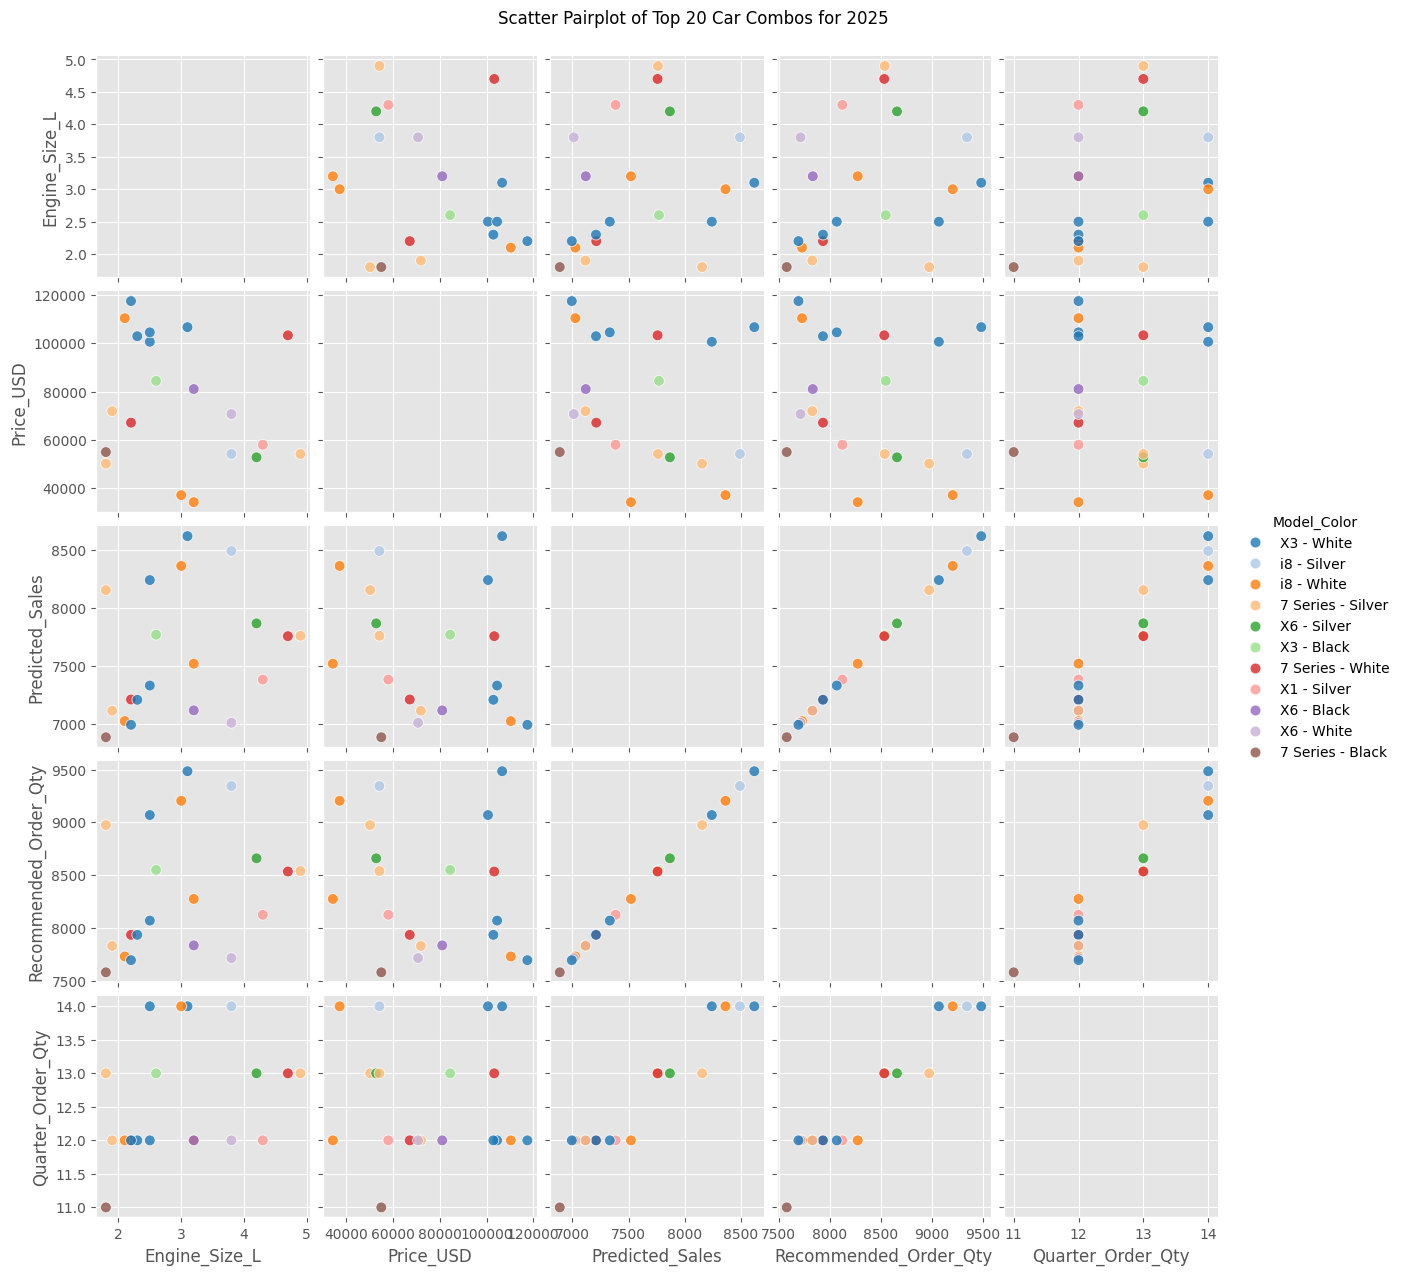

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------------
# 1) Assume top_recs_real already exists
# ----------------------------
ORDER_MULTIPLE = 5
SAFETY_FACTOR = 0.10
TOTAL_CARS_PER_QUARTER = 250

def round_up_to_multiple(x, multiple):
    return int(np.ceil(x * (1 + SAFETY_FACTOR) / multiple) * multiple)

top_recs_real["Recommended_Order_Qty"] = top_recs_real["Predicted_Sales"].apply(
    lambda x: round_up_to_multiple(x, ORDER_MULTIPLE)
)

top_recs_real["Quarter_Order_Qty"] = (
    top_recs_real["Recommended_Order_Qty"] / top_recs_real["Recommended_Order_Qty"].sum() * TOTAL_CARS_PER_QUARTER
).round().astype(int)

# ----------------------------
# 2) Group by (Model, Color)
# ----------------------------
models_data = top_recs_real.groupby(["Model", "Color"])["Quarter_Order_Qty"].sum().to_dict()

# ----------------------------
# 3) Allocation function: min per color + proportional adjustment
# ----------------------------
def calculate_dealership_allocation_proportional(total_units, models_data, min_units=ORDER_MULTIPLE):
    total_weight = sum(models_data.values())
    allocation = {}

    # Step 1: Assign minimum proportional allocation
    for key, weight in models_data.items():
        alloc = max(round((weight / total_weight) * total_units), min_units)
        allocation[key] = alloc

    # Step 2: Adjust to match total_units
    allocated_units = sum(allocation.values())
    difference = total_units - allocated_units

    if difference != 0:
        # Distribute difference proportionally based on original weights
        total_weight_remaining = sum(models_data.values())
        for key, weight in models_data.items():
            add_units = round((weight / total_weight_remaining) * difference)
            allocation[key] += add_units

        # Final check: adjust any rounding discrepancy
        final_diff = total_units - sum(allocation.values())
        if final_diff != 0:
            # Add/subtract the remaining difference to the highest weight combo
            highest_weight_key = max(models_data.keys(), key=lambda k: models_data[k])
            allocation[highest_weight_key] += final_diff

    return allocation, total_weight

# Calculate allocation
allocation, total_weight = calculate_dealership_allocation_proportional(
    TOTAL_CARS_PER_QUARTER, models_data
)

# ----------------------------
# 4) Display allocation
# ----------------------------
print("=== DEALERSHIP INVENTORY ALLOCATION ===")
print(f"Total Units to Allocate: {TOTAL_CARS_PER_QUARTER}")
print(f"Total Weight: {total_weight}")
print("\nAllocation per Model & Color:")
print("-" * 50)

for (model, color), units in sorted(allocation.items(), key=lambda x: x[1], reverse=True):
    weight = models_data[(model, color)]
    percentage = (units / TOTAL_CARS_PER_QUARTER) * 100
    print(f"{model:<12} | {color:<10}: {units:>3} units ({weight:>4} weight, {percentage:>5.1f}%)")

# ----------------------------
# 5) Scatter pairplot of top 20 combos
# ----------------------------
top_20 = top_recs_real.nlargest(20, "Predicted_Sales").copy()
top_20["Model_Color"] = top_20["Model"] + " - " + top_20["Color"]

numeric_cols = ["Engine_Size_L", "Price_USD", "Predicted_Sales", "Recommended_Order_Qty", "Quarter_Order_Qty"]

sns.pairplot(
    top_20,
    vars=numeric_cols,
    hue="Model_Color",
    palette="tab20",
    diag_kind="scatter",
    plot_kws={"s": 60, "alpha": 0.8}
)

plt.suptitle("Scatter Pairplot of Top 20 Car Combos for 2025", y=1.02)
plt.show()


In [ ]:
!pip install streamlit pyngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 80.1 MB/s eta 0:00:00


Overwriting bmw_dashboard.py





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.23.111.49:8501

